In [4]:
from djccx.frd.readfrd import readfrd
from matplotlib import pyplot as plt
from validation.FullExperimental import FullExperimental
import os, glob
import numpy as np

In [5]:
params = {
            "geo" : {
                        "t_n" : 2.51,
                        "t_l" : 0.5,
                        "Lx"  : 30,
                        "Ly"  : 25
                    },
            "sim" : {
                        "disp" : 0.5,
                    },
            "tensile" : {
                        "disp" : 2.0,
                    },
        }

In [6]:
epsilon_tensile = params["tensile"]["disp"] / params["geo"]["Ly"]
eps_span = np.linspace(0, epsilon_tensile, 4)
print(eps_span)

[0.         0.02666667 0.05333333 0.08      ]


In [7]:
from AnalyticalLayers.models import Tau_model

In [8]:
composition = [
        ["Y", "Y"],
        ["Y", "X"],
        ["Y", "SX"],
        ["Y", "SY"],
        ["Y", "SX" , "SY"],
        ["Y", "X"  , "SY"]
    ]
ni = [ len(c) for c in composition ]

In [9]:
tn = params["geo"]["t_n"]
tl = params["geo"]["t_l"]
Lx = params["geo"]["Lx"]

tt = [ Tau_model(tn,tl,ini) for ini in ni ]
tt = np.array(tt)


In [10]:
df_exp = FullExperimental() 

In [11]:
df_exp.pop("Eb [GPa]")
df_exp.pop("Et [GPa]")
df_exp.pop("Vc")

Name
TFP1    0.178
TFP2    0.164
TFP3    0.135
TFP4    0.144
TFP5    0.146
TFP6    0.180
Name: Vc, dtype: float64

In [12]:
df_exp

% e            Smax [MPa]               t [mm]            \
          mean       std        mean        std      mean       std   
Name                                                                  
TFP1  0.123306  0.009827  279.103333  14.337700  5.266667  0.057735   
TFP2  0.087556  0.002840  153.360000   0.473181  4.700000  0.000000   
TFP3  0.087444  0.002164  137.113333   4.996812  4.833333  0.057735   
TFP4  0.095472  0.005491  184.396667   1.356515  4.700000  0.000000   
TFP5  0.089889  0.013757   99.990000   9.790138  5.700000  0.000000   
TFP6  0.089083  0.010304  104.513333   7.708893  5.600000  0.000000   

         b [mm]                 layers  
           mean       std               
Name                                    
TFP1  25.600000  0.100000          [Y]  
TFP2  25.566667  0.057735       [Y, X]  
TFP3  25.400000  0.173205      [Y, SX]  
TFP4  25.666667  0.152753      [Y, SY]  
TFP5  25.166667  0.152753  [Y, SX, SY]  
TFP6  25.033333  0.635085   [Y, X, SY]

In [13]:
St = df_exp["Smax [MPa]"]["mean"]

In [14]:
St = np.array([256.88057426, 146.37908435, 130.73891314, 183.43036528,
       106.30559521, 112.76523383])

In [15]:
St

array([256.88057426, 146.37908435, 130.73891314, 183.43036528,
       106.30559521, 112.76523383])

In [16]:
import pandas as pd

results = pd.read_csv("output.csv")

In [17]:
frds = glob.glob("output/*/tensile/*.frd")
inps = glob.glob("output/*/tensile/*.inp")
stress_test = [ p.replace("tensile","stress") for p in inps ]


In [18]:
# createe folders 
for p in stress_test:
    try:
        os.makedirs(p, exist_ok=True)
    except:
        pass

In [19]:
from djccx.inp.inp import inp

In [20]:
import numpy as np

In [21]:
St_layers = {
    "X"   : 51.1,  # MPa
    "SX"  : 72.8,  # MPa
    "Y"   : 741.4,   # MPa
    "SY"  : 111.3, # MPa
    "nucleo" : 0.0,
}

St_TFP = [ 279.1, 153.4 , 137.1 , 184.4 , 100.0 , 104.5 ]

In [34]:
788*153.4/1797

67.26722314969395

In [41]:

TPF = 2
inp_f = inp(inps[TPF])
ifrd = readfrd(frds[TPF])
LAYERS =  inp_f.elements

YLs = inp_f.select_regex(".*YL_.*","nset")
icomp = [ *composition[TPF][::-1] , "nucleo", *composition[TPF] ]

ti = np.array([tl for i in range(len(icomp))])
ti[len(icomp)//2] = tn

A = ti*Lx
print(icomp)

rr = []
for data in ifrd["data_blocks"]:
    F2s = []
    S2s = []
    
    # ========================
    # Principal Stress
    # ========================
    P1s = []

    for idx in range(len(LAYERS)):
        nodes = LAYERS[idx].GetUniqueNodes(inp_f.nodes)
        P1max = np.max(data.loc[nodes.index]["P1"])
        P1s.append(P1max)

    P1s = np.array(P1s)
    # ========================
    # Force By layers
    # ========================
    
    for idx in range(len(YLs)):
        df = data.loc[YLs[idx].id_nodes]
        F2 = df["F2"].sum()
        F2s.append(F2)
        S2 = F2/A[idx]
        S2s.append(S2)

    S2s = np.array(S2s)
    # ========================
    # Total Force
    # ========================

    F2 = data["F2"]
    y = data["y"]
    ymean = F2.mean()
    A_ly1 = Lx*tt[TPF]
    F2_tot = F2[y>y.mean()].sum()
    sigma_tot = F2_tot.sum()/A_ly1

    r = { 
        "Sapl_by_layers" : S2s,
        "Sapl" : sigma_tot,
        "layers" : icomp,
        "P1" : P1s,
    }
    rr.append(r)


['SX', 'Y', 'nucleo', 'Y', 'SX']


In [42]:
Sapl_time = [ r["Sapl"] for r in rr ]
L1 = [ r["Sapl_by_layers"][0] for r in rr ]
L2 = [ r["Sapl_by_layers"][1] for r in rr ]
L3 = [ r["Sapl_by_layers"][2] for r in rr ]
L4 = [ r["Sapl_by_layers"][3] for r in rr ]
L5 = [ r["Sapl_by_layers"][4] for r in rr ]

Ls = [ L1, L2, L3, L4, L5 ]

In [43]:
L1 = [ r["P1"][0] for r in rr ]
L2 = [ r["P1"][1] for r in rr ]
L3 = [ r["P1"][2] for r in rr ]
L4 = [ r["P1"][3] for r in rr ]
L5 = [ r["P1"][4] for r in rr ]

P1s = [ L1, L2, L3, L4, L5 ]


In [44]:
epsilon_tensile

0.08

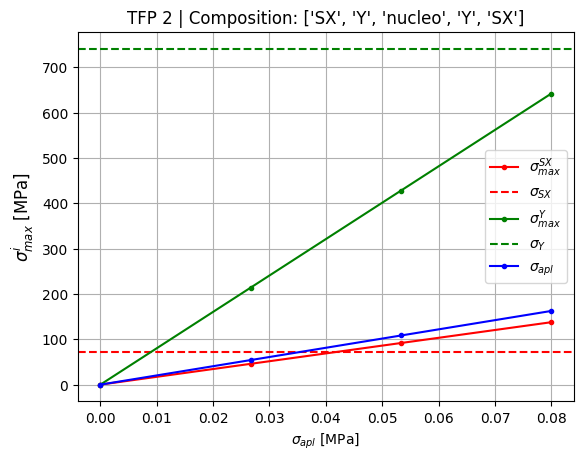

In [45]:

colors = ["r","g","k"]
for i,L in enumerate(Ls):
    if i>len(Ls)//2:
        break
    ly = rr[0]["layers"][i]
    St_layer = St_layers[ly]
    if ly != "nucleo":

        plt.plot(eps_span,L,'.-',label=r"$\sigma_{max}^{"+ly + "}$",
                    color=colors[i])
        plt.axhline(St_layer,linestyle="--",color=colors[i],label=r"$\sigma_{"+ly+"}$")


plt.plot(eps_span,Sapl_time,'.-',label=r"$\sigma_{apl}$",color="b")
plt.legend()
plt.ylabel(r"$\sigma_{max}^{i}$ [MPa]",fontsize=12)
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
#  Mpa vertical line
# plt.axvline(St_TFP[TPF],linestyle="--",color="k")
plt.title("TFP "+str(TPF) + " | Composition: " + str(icomp))
plt.grid()

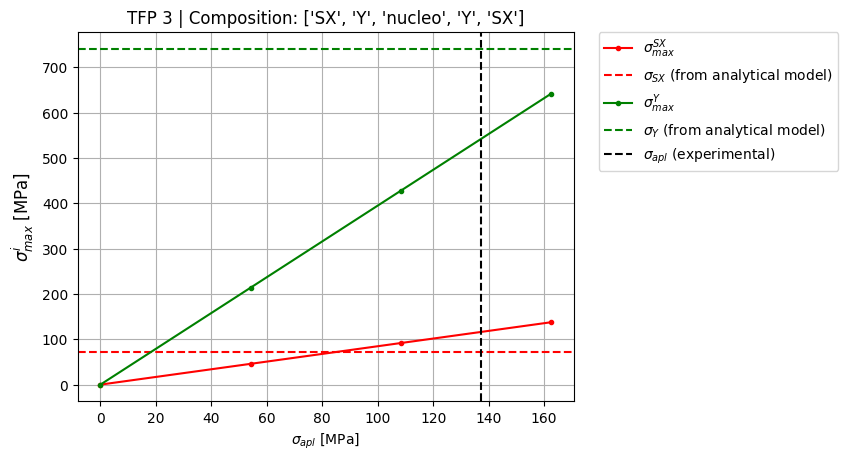

In [46]:

colors = ["r","g","k"]
for i,L in enumerate(Ls):
    if i>len(Ls)//2:
        break
    ly = rr[0]["layers"][i]
    St_layer = St_layers[ly]
    if ly != "nucleo":

        plt.plot(Sapl_time,L,'.-',label=r"$\sigma_{max}^{"+ly + "}$",
                    color=colors[i])
        plt.axhline(St_layer,
                    linestyle="--",
                    color=colors[i],
                    label=r"$\sigma_{"+ly+"}$ (from analytical model)")
        
plt.ylabel(r"$\sigma_{max}^{i}$ [MPa]",fontsize=12)
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
#  Mpa vertical line
plt.axvline(St_TFP[TPF],linestyle="--",
            color="k",
            label=r"$\sigma_{apl}$ (experimental)")
plt.title("TFP "+str(TPF+1) + " | Composition: " + str(icomp))
plt.grid()
# outside
plt.legend( bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           borderaxespad=0.)
